# Forward Risk Notebook — Sektion 1: Model Setup & IM Herleitung

- Wir setzen das ökonomische Grundmodell für einen Forward-Kontrakt auf.
- Wir leiten die Initial Margin (IM) als one-sided VaR über den MPOR sauber her.
- Wir bereiten Parameter für Forward-MTM, Margins und spätere Defaults/Policies vor.

## Block 1.1 — Economic Setup

**Institution A (Investor):** long Forward, mit begrenzter Liquidität (relevant für später).

**Institution B (Dealer):** jederzeit liquide, kein Default.

**Kontrakt:** Forward auf \(S\), Position \(Q\), Strike \(K\).

**MTM aus Sicht von A:**

\[
V_t = Q\,(S_t - K)
\]


## Block 1.2 — IM Herleitung

Annahme für die Preisänderung über \(\Delta\):

\[
`S_{t+\Delta} - S_t \sim \mathcal{N}(0,\,\Delta\,\sigma_s^2)`
\]

Da \(V_t = Q(S_t-K)\), folgt für die MTM-Änderung:

\[
V_{t+\Delta} - V_t = Q\,(S_{t+\Delta} - S_t)
\]

Also verteilt sich die MTM-Änderung als:

\[
V_{t+\Delta} - V_t \sim \mathcal{N}(0,\,Q^2\,\Delta\,\sigma_s^2)
\]

Standardabweichung über \(\Delta\):

\[
\sigma_{\Delta V} = |Q|\,\sigma_s\,\sqrt{\Delta}
\]

Initial Margin als one-sided \(\mathrm{VaR}_{0.99}\) über den MPOR:

\[
\mathrm{IM} = z_{0.99}\,|Q|\,\sigma_s\,\sqrt{\mathrm{MPOR}}
\]

mit

\[
z_{0.99} = \Phi^{-1}(0.99) \approx 2.326.
\]


## Block 1.3 — Imports & Parameter

Wir laden die Kernbibliotheken und definieren ein editierbares `params`-Dictionary als zentrale Modell-Konfiguration.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from statistics import NormalDist

params = {
    "N": 6000,
    "T_sim": 252,
    "S0": 100.0,
    "K": 100.0,
    "Q": 100.0,
    "sigma_s": 0.30,
    "MPOR": 10,
    "PD_annual": 0.20,
    "seed": 42,
    "L0": 50_000.0,
    "A0": 150_000.0,
    "h": 0.10,
    "VM_freq": 1,
    "IM_conf": 0.99,
    "IM_mult": 1.0,
}

rng = np.random.default_rng(params["seed"])

pd.Series(params)

N              6000.00
T_sim           252.00
S0              100.00
K               100.00
Q               100.00
sigma_s           0.30
MPOR             10.00
PD_annual         0.20
seed             42.00
L0            50000.00
A0           150000.00
h                 0.10
VM_freq           1.00
IM_conf           0.99
IM_mult           1.00
dtype: float64

## Block 1.4 — Helper Functions

Wir definieren Funktionen für die Umrechnung von jährlicher auf tägliche Default-Wahrscheinlichkeit und für die IM-Berechnung aus der Herleitung.

In [10]:
def annual_pd_to_daily(PD_annual, days=252):
    lam = -log(1 - PD_annual)
    p_day = 1 - np.exp(-lam / days)
    return p_day


def compute_im(Q, sigma_s, MPOR, conf=0.99, mult=1.0):
    z = NormalDist().inv_cdf(conf)
    IM = mult * z * abs(Q) * sigma_s * sqrt(MPOR)
    return IM, z


p_day = annual_pd_to_daily(params["PD_annual"])
IM, z = compute_im(
    Q=params["Q"],
    sigma_s=params["sigma_s"],
    MPOR=params["MPOR"],
    conf=params["IM_conf"],
    mult=params["IM_mult"],
)

print("z =", round(z, 6))
print("p_day =", round(p_day, 8))
print("IM =", round(IM, 4))

z = 2.326348
p_day = 0.0008851
IM = 220.6967


## Block 2.1 — Market Simulation

- Wir simulieren Spot-Preise \(S_t\) über 252 Tage.
- Inkremente: \(S_{t+1} - S_t \sim \mathcal{N}(0, \sigma_s^2)\).
- Es gibt keine Drift.
- Wir simulieren bis \(T_{sim}+MPOR\), damit ein Closeout bei \(t+MPOR\) möglich ist.
- Das MTM lautet: \(V_t = Q(S_t-K)\).


## Block 2.2 — `simulate_market_paths()`

Wir implementieren die Marktsimulation und prüfen das Ergebnis direkt über Pfad-Plot und Array-Formate.


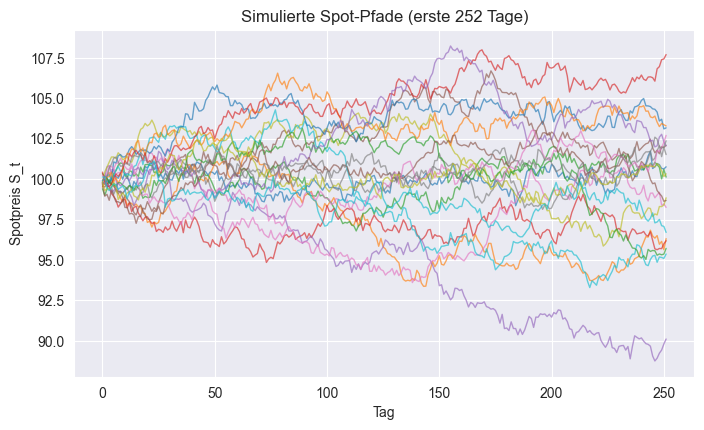

S shape = (6000, 262)
V shape = (6000, 262)


In [11]:
def simulate_market_paths(N, T_sim, MPOR, S0, sigma_s, K, Q, seed):
    T_full = T_sim + MPOR
    rng_local = np.random.default_rng(seed)
    dS = rng_local.normal(loc=0.0, scale=sigma_s, size=(N, T_full))
    S = S0 + np.cumsum(dS, axis=1)
    V = Q * (S - K)
    return S, V


S, V = simulate_market_paths(
    N=params["N"],
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    S0=params["S0"],
    sigma_s=params["sigma_s"],
    K=params["K"],
    Q=params["Q"],
    seed=params["seed"],
)

fig, ax = plt.subplots(figsize=(8, 4.5))
path_idx = rng.choice(params["N"], size=min(20, params["N"]), replace=False)
for idx in path_idx:
    ax.plot(S[idx, : params["T_sim"]], alpha=0.65, linewidth=1.0)
ax.set_title("Simulierte Spot-Pfade (erste 252 Tage)")
ax.set_xlabel("Tag")
ax.set_ylabel("Spotpreis S_t")
plt.show()

print("S shape =", S.shape)
print("V shape =", V.shape)


## Block 2.3 — Exogenous Default Probability

- Default ist exogen und unabhängig von Liquidität.
- Die jährliche PD wird in eine tägliche PD umgerechnet.
- Ein täglicher Default-Trigger wird per Uniform\((0,1)\)-Zufallszahl simuliert.


## Block 2.4 — Baseline Engine

Wir implementieren den Baseline-Fall mit exogenem Default, IM und VM-Frequenz, ohne Liquidity-Modell und ohne Policy-Mechanismen.


In [12]:
def run_baseline_exogenous(V, p_day, IM, T_sim, MPOR, VM_freq, seed):
    N = V.shape[0]
    losses = np.zeros(N)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, -1, dtype=int)

    rng_local = np.random.default_rng(seed)

    for i in range(N):
        last_settled_mtm = V[i, 0]
        for t in range(1, T_sim + 1):
            if t % VM_freq == 0:
                last_settled_mtm = V[i, t]

            if rng_local.random() < p_day:
                default_flag[i] = True
                default_day[i] = t

                t_close = min(t + MPOR, V.shape[1] - 1)
                V_close = V[i, t_close]
                amount_owed_to_B = max(0.0, -V_close)
                vm_held_by_B = max(0.0, last_settled_mtm - V[i, t])
                collateral_available = IM + vm_held_by_B
                loss = max(0.0, amount_owed_to_B - collateral_available)
                losses[i] = loss
                break

    return {
        "losses": losses,
        "default_flag": default_flag,
        "default_day": default_day,
    }


p_day = annual_pd_to_daily(params["PD_annual"])
IM, z = compute_im(
    Q=params["Q"],
    sigma_s=params["sigma_s"],
    MPOR=params["MPOR"],
    conf=params["IM_conf"],
    mult=params["IM_mult"],
)

baseline = run_baseline_exogenous(
    V=V,
    p_day=p_day,
    IM=IM,
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    VM_freq=params["VM_freq"],
    seed=params["seed"],
)

num_defaults = int(baseline["default_flag"].sum())
default_rate = baseline["default_flag"].mean()
max_loss = float(np.max(baseline["losses"]))

print(f"Anzahl Defaults = {num_defaults}")
print(f"Default Rate = {default_rate:.4%}")
print(f"Max Loss = {max_loss:.6f}")


Anzahl Defaults = 1184
Default Rate = 19.7333%
Max Loss = 983.533342


## Block 2.5 — Baseline Risk Metrics

Aus der unbedingten Loss-Verteilung berechnen wir Erwartungsverlust (EL), VaR und ES bei 99%.


In [13]:
def risk_metrics(losses, alpha=0.99):
    losses = np.asarray(losses)
    EL = float(np.mean(losses))
    VaR = float(np.quantile(losses, alpha))
    tail_losses = losses[losses >= VaR]
    ES = float(np.mean(tail_losses)) if tail_losses.size > 0 else VaR
    return EL, VaR, ES


EL, VaR99, ES99 = risk_metrics(baseline["losses"], alpha=0.99)
print(f"EL = {EL:.6f}")
print(f"VaR99 = {VaR99:.6f}")
print(f"ES99 = {ES99:.6f}")


EL = 9.745590
VaR99 = 341.582972
ES99 = 514.684655


## Block 2.6 — Loss Distribution Plot

Wir visualisieren die unbedingte Verteilung aller Baseline-Losses als Histogramm.


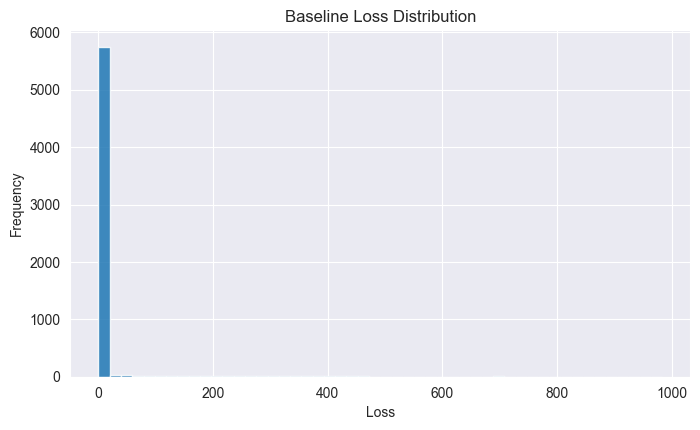

Anzahl Verluste > 0: 270


In [14]:
plt.figure(figsize=(8, 4.5))
plt.hist(baseline["losses"], bins=50, alpha=0.85, edgecolor="white")
plt.title("Baseline Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()

print("Anzahl Verluste > 0:", int(np.sum(baseline["losses"] > 0)))


## Block 3.1 — Liquidity Extension Erklärung

- Investor A hält Liquidität \(L_0\) und illiquide Assets \(A_0\).
- A muss Margin-Zahlungen (VM und IM) leisten.
- Reicht Cash nicht, verkauft A illiquide Assets mit Haircut \(h\) (Fire Sale).
- Für Shortfall gilt verkaufter Nominalwert: \(`shortfall/(1-h)`\); Fire-sale-Kosten: \(h\cdot sold\_nominal\).
- Reichen Cash und illiquide Assets nicht aus, entsteht ein Liquidity Default.
- Exogene Defaults bleiben zusätzlich aktiv; der frühere Default zählt.


In [15]:
liquidity_preview = pd.DataFrame([
    {
        "L0": params["L0"],
        "A0": params["A0"],
        "h": params["h"],
        "IM": IM,
        "p_day": p_day,
        "max_cash_from_illiquid": params["A0"] * (1 - params["h"]),
    }
])
print("Liquidity setup preview:")
liquidity_preview


Liquidity setup preview:


,L0,A0,h,IM,p_day,max_cash_from_illiquid
0,50000.0,150000.0,0.1,220.696737,0.000885,135000.0


## Block 3.2 — Augmented Engine

Wir erweitern die Baseline um Cash- und Fire-Sale-Dynamik, behalten aber den exogenen Default-Prozess bei.


In [16]:
def run_augmented_liquidity(V, p_day, IM, T_sim, MPOR, VM_freq, L0, A0, h, seed):
    if h >= 1.0:
        raise ValueError("h must be < 1.0")

    N = V.shape[0]
    losses = np.zeros(N)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, -1, dtype=int)
    default_type = np.full(N, None, dtype=object)
    fire_sale_cost = np.zeros(N)
    fire_sale_events = np.zeros(N, dtype=int)

    rng_local = np.random.default_rng(seed)

    for i in range(N):
        cash = float(L0)
        illiquid = float(A0)
        fire_sale_cost_total = 0.0
        fire_sale_events_total = 0
        last_settled_mtm = V[i, 0]

        def pay_with_liquidity(payment):
            nonlocal cash, illiquid, fire_sale_cost_total, fire_sale_events_total
            if payment <= 0:
                return True
            if cash >= payment:
                cash -= payment
                return True

            shortfall = payment - cash
            cash = 0.0
            sold_nominal = shortfall / (1.0 - h)
            illiquid -= sold_nominal
            fire_sale_cost_total += h * sold_nominal
            fire_sale_events_total += 1
            return illiquid >= 0.0

        # 1) IM funding at t=0
        if not pay_with_liquidity(IM):
            default_flag[i] = True
            default_day[i] = 0
            default_type[i] = "liquidity"

            t_close = min(MPOR, V.shape[1] - 1)
            V_close = V[i, t_close]
            amount_owed_to_B = max(0.0, -V_close)
            collateral_available = 0.0
            losses[i] = max(0.0, amount_owed_to_B - collateral_available)

            fire_sale_cost[i] = fire_sale_cost_total
            fire_sale_events[i] = fire_sale_events_total
            continue

        # 2-3) VM settlement then exogenous default check
        for t in range(1, T_sim + 1):
            vm_transfer = 0.0

            if t % VM_freq == 0:
                vm_transfer = V[i, t] - last_settled_mtm
                if vm_transfer < 0.0:
                    payment = -vm_transfer
                    if not pay_with_liquidity(payment):
                        default_flag[i] = True
                        default_day[i] = t
                        default_type[i] = "liquidity"

                        t_close = min(t + MPOR, V.shape[1] - 1)
                        V_close = V[i, t_close]
                        amount_owed_to_B = max(0.0, -V_close)
                        vm_held_by_B = max(0.0, -vm_transfer)
                        collateral_available = IM + vm_held_by_B
                        losses[i] = max(0.0, amount_owed_to_B - collateral_available)
                        break

                last_settled_mtm = V[i, t]

            if rng_local.random() < p_day:
                default_flag[i] = True
                default_day[i] = t
                default_type[i] = "exogenous"

                t_close = min(t + MPOR, V.shape[1] - 1)
                V_close = V[i, t_close]
                amount_owed_to_B = max(0.0, -V_close)
                vm_held_by_B = max(0.0, last_settled_mtm - V[i, t])
                collateral_available = IM + vm_held_by_B
                losses[i] = max(0.0, amount_owed_to_B - collateral_available)
                break

        fire_sale_cost[i] = fire_sale_cost_total
        fire_sale_events[i] = fire_sale_events_total

    return {
        "losses": losses,
        "default_flag": default_flag,
        "default_day": default_day,
        "default_type": default_type,
        "fire_sale_cost": fire_sale_cost,
        "fire_sale_events": fire_sale_events,
    }


augmented = run_augmented_liquidity(
    V=V,
    p_day=p_day,
    IM=IM,
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    VM_freq=params["VM_freq"],
    L0=params["L0"],
    A0=params["A0"],
    h=params["h"],
    seed=params["seed"],
)

total_defaults = int(np.sum(augmented["default_flag"]))
exo_defaults = int(np.sum(augmented["default_type"] == "exogenous"))
liq_defaults = int(np.sum(augmented["default_type"] == "liquidity"))

print(f"total defaults = {total_defaults}")
print(f"exogenous defaults = {exo_defaults}")
print(f"liquidity defaults = {liq_defaults}")
print(f"mean fire_sale_cost = {np.mean(augmented['fire_sale_cost']):.6f}")
print(f"mean fire_sale_events = {np.mean(augmented['fire_sale_events']):.6f}")
print(f"max loss = {np.max(augmented['losses']):.6f}")


total defaults = 1184
exogenous defaults = 1184
liquidity defaults = 0
mean fire_sale_cost = 0.000000
mean fire_sale_events = 0.000000
max loss = 983.533342


## Block 3.3 — Vergleich Baseline vs Augmented

Wir vergleichen beide Modelle über Risiko-, Default- und Fire-Sale-Kennzahlen in einer kompakten Tabelle.


In [17]:
EL_b, VaR99_b, ES99_b = risk_metrics(baseline["losses"], alpha=0.99)
EL_a, VaR99_a, ES99_a = risk_metrics(augmented["losses"], alpha=0.99)

summary = pd.DataFrame([
    {
        "model": "baseline",
        "EL": EL_b,
        "VaR99": VaR99_b,
        "ES99": ES99_b,
        "default_rate_total": float(np.mean(baseline["default_flag"])),
        "default_rate_exo": float(np.mean(baseline["default_flag"])),
        "default_rate_liq": 0.0,
        "mean_fire_sale_cost": 0.0,
        "mean_fire_sale_events": 0.0,
    },
    {
        "model": "augmented",
        "EL": EL_a,
        "VaR99": VaR99_a,
        "ES99": ES99_a,
        "default_rate_total": float(np.mean(augmented["default_flag"])),
        "default_rate_exo": float(np.mean(augmented["default_type"] == "exogenous")),
        "default_rate_liq": float(np.mean(augmented["default_type"] == "liquidity")),
        "mean_fire_sale_cost": float(np.mean(augmented["fire_sale_cost"])),
        "mean_fire_sale_events": float(np.mean(augmented["fire_sale_events"])),
    },
])

summary


,model,EL,VaR99,ES99,default_rate_total,default_rate_exo,default_rate_liq,mean_fire_sale_cost,mean_fire_sale_events
0,baseline,9.74559,341.582972,514.684655,0.197333,0.197333,0.0,0.0,0.0
1,augmented,9.74559,341.582972,514.684655,0.197333,0.197333,0.0,0.0,0.0


## Block 3.4 — Loss Distribution Vergleich

Wir vergleichen unbedingte und bedingte Loss-Verteilungen von Baseline und Augmented.


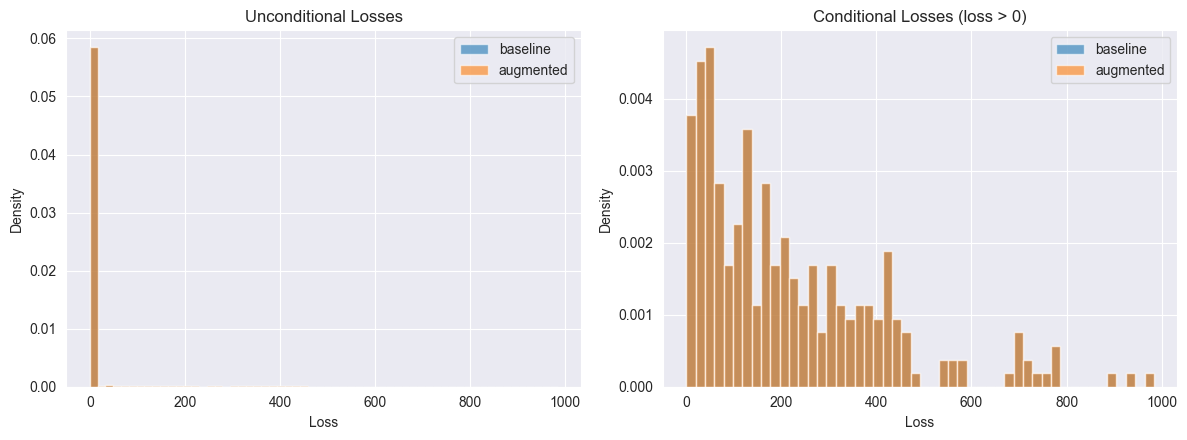

n(loss>0) baseline = 270
n(loss>0) augmented = 270


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

axes[0].hist(baseline["losses"], bins=60, density=True, alpha=0.6, label="baseline")
axes[0].hist(augmented["losses"], bins=60, density=True, alpha=0.6, label="augmented")
axes[0].set_title("Unconditional Losses")
axes[0].set_xlabel("Loss")
axes[0].set_ylabel("Density")
axes[0].legend()

loss_b_pos = baseline["losses"][baseline["losses"] > 0]
loss_a_pos = augmented["losses"][augmented["losses"] > 0]
axes[1].hist(loss_b_pos, bins=50, density=True, alpha=0.6, label="baseline")
axes[1].hist(loss_a_pos, bins=50, density=True, alpha=0.6, label="augmented")
axes[1].set_title("Conditional Losses (loss > 0)")
axes[1].set_xlabel("Loss")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()
print("n(loss>0) baseline =", int(loss_b_pos.size))
print("n(loss>0) augmented =", int(loss_a_pos.size))


## Block 3.5 — Fire Sales Severity

Wir messen Häufigkeit und Kosten von Fire Sales und visualisieren die positive Kostenverteilung.


Anteil Pfade mit fire_sale_events > 0: 0.0000%
mean fire_sale_cost (>0) = 0.000000
median fire_sale_cost (>0) = 0.000000


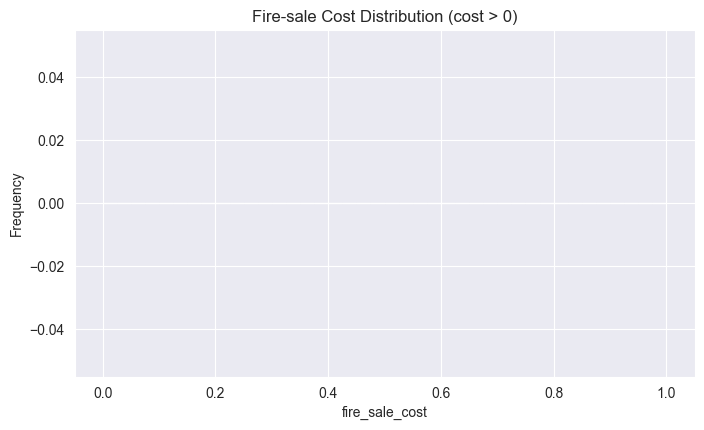

In [19]:
fs_cost = augmented["fire_sale_cost"]
fs_cost_pos = fs_cost[fs_cost > 0]
share_fire_sales = float(np.mean(augmented["fire_sale_events"] > 0))

print(f"Anteil Pfade mit fire_sale_events > 0: {share_fire_sales:.4%}")
if fs_cost_pos.size > 0:
    print(f"mean fire_sale_cost (>0) = {np.mean(fs_cost_pos):.6f}")
    print(f"median fire_sale_cost (>0) = {np.median(fs_cost_pos):.6f}")
else:
    print("mean fire_sale_cost (>0) = 0.000000")
    print("median fire_sale_cost (>0) = 0.000000")

plt.figure(figsize=(8, 4.5))
plt.hist(fs_cost_pos, bins=40, alpha=0.85, edgecolor="white")
plt.title("Fire-sale Cost Distribution (cost > 0)")
plt.xlabel("fire_sale_cost")
plt.ylabel("Frequency")
plt.show()
